<a href="https://colab.research.google.com/github/nicolenair/fine-tune-MaskRcnn/blob/master/haochen_mask_r_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive')
#https://haochen23.github.io/2020/06/fine-tune-mask-rcnn.html#.Xvj9Bmozau4

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install tensorflow-gpu==1.15.0rc0
!pip install keras==2.2.5

In [3]:
# !git clone https://github.com/matterport/Mask_RCNN.git
os.chdir("Mask_RCNN")
!python setup.py install
# !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/utils.py to utils.cpyt

In [4]:
os.chdir('..')
# !git clone https://github.com/haochen23/fine-tune-MaskRcnn.git
os.chdir('fine-tune-MaskRcnn')

In [5]:
!python3 beagle.py train --dataset=beagle --weights=coco --epochs=50

Using TensorFlow backend.
usage: beagle.py [-h] [--dataset /path/to/custom/dataset/] --weights
                 /path/to/weights.h5 [--logs /path/to/logs/]
                 [--image path or URL to image] [--video path or URL to video]
                 <command>
beagle.py: error: unrecognized arguments: --epochs=50


In [5]:
%matplotlib inline
os.chdir('Mask_RCNN')
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
ROOT_DIR = os.path.abspath("../")
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import beagle
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_WEIGHTS_PATH = ROOT_DIR +"/beagle_mask_rcnn_coco.h5"

Using TensorFlow backend.


In [6]:
config = beagle.CustomConfig()
BEAGLE_DIR = ROOT_DIR+"/beagle"

In [7]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [8]:
# set target device
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

In [9]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [10]:
dataset = beagle.CustomDataset()
dataset.load_custom(BEAGLE_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 10
Classes: ['BG', 'beagle']


In [11]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Use `tf.cast` instead.


In [12]:
os.listdir('../../logs')

['beagle20200628T2059',
 'beagle20200630T0543',
 'beagle20200630T0642',
 'beagle20200630T0901']

In [13]:
weights_path = "../../logs/beagle20200630T0901/mask_rcnn_beagle_0010.h5"
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  ../../logs/beagle20200630T0901/mask_rcnn_beagle_0010.h5
Re-starting from epoch 10


image ID: beagle.Jean_Chretien_0031.png (5) /content/gdrive/My Drive/fine-tune-MaskRcnn/beagle/val/Jean_Chretien_0031.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  281.00000  max:  772.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


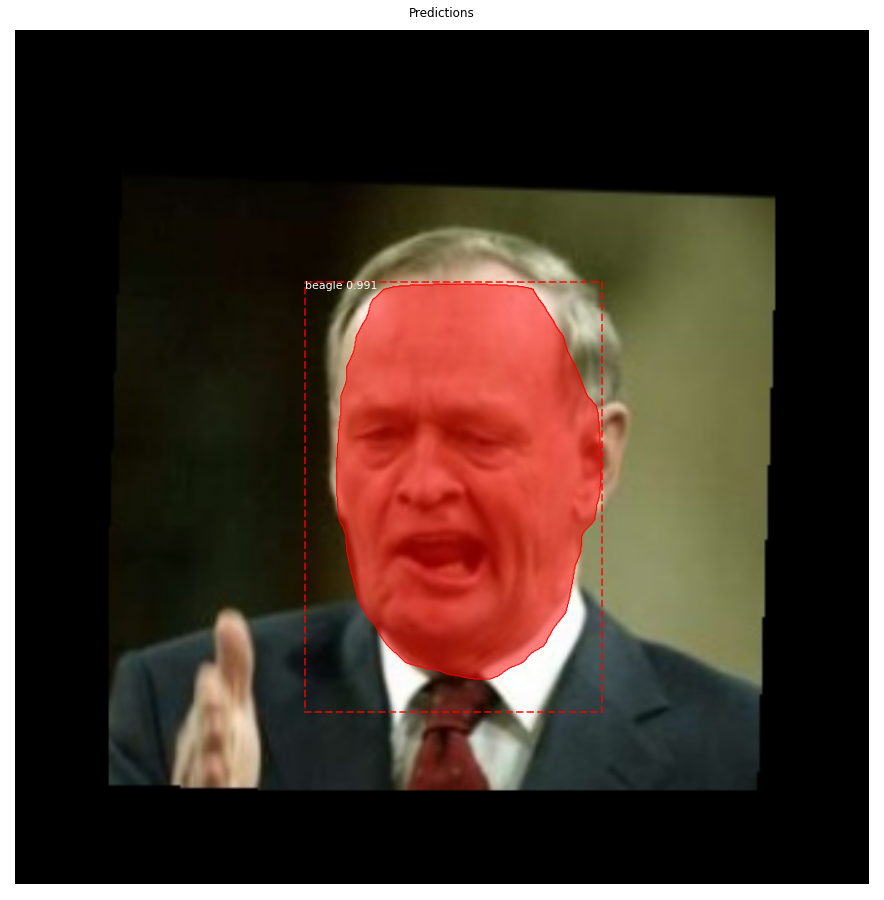

In [15]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [17]:
from google.colab.patches import cv2_imshow
import cv2
src1 = image
src1_mask=cv2.cvtColor((r['masks'] * 255).astype(np.uint8),cv2.COLOR_GRAY2BGR)#change mask to a 3 channel image 
mask_out=cv2.subtract(src1_mask,src1)
mask_out=cv2.subtract(src1_mask,mask_out)

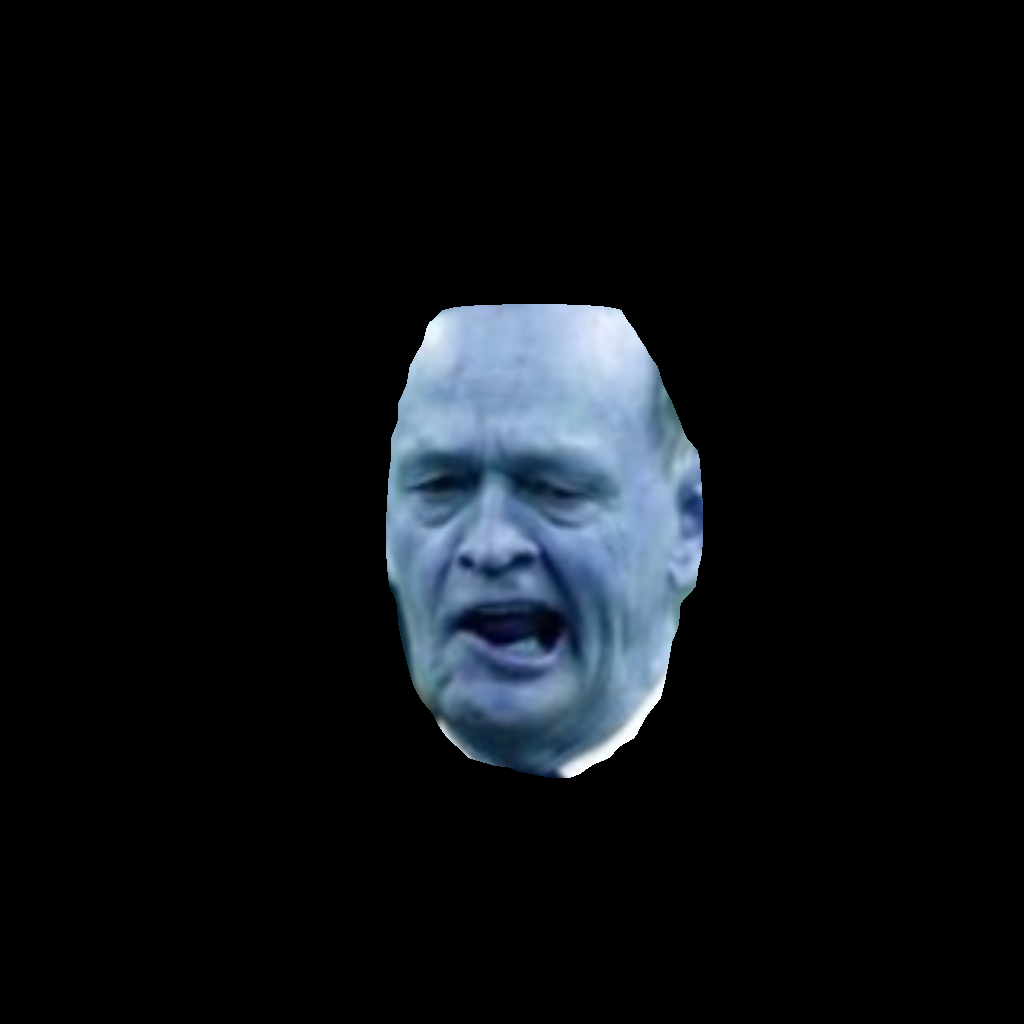

In [19]:
cv2_imshow(mask_out)

In [20]:
os.listdir()

['.git',
 '.gitignore',
 'LICENSE',
 'MANIFEST.in',
 'README.md',
 'assets',
 'images',
 'mrcnn',
 'requirements.txt',
 'samples',
 'setup.cfg',
 'setup.py']

Saving john paul sartre.jpg to john paul sartre (1).jpg
Processing 1 images
image                    shape: (513, 450, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  281.00000  max:  772.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


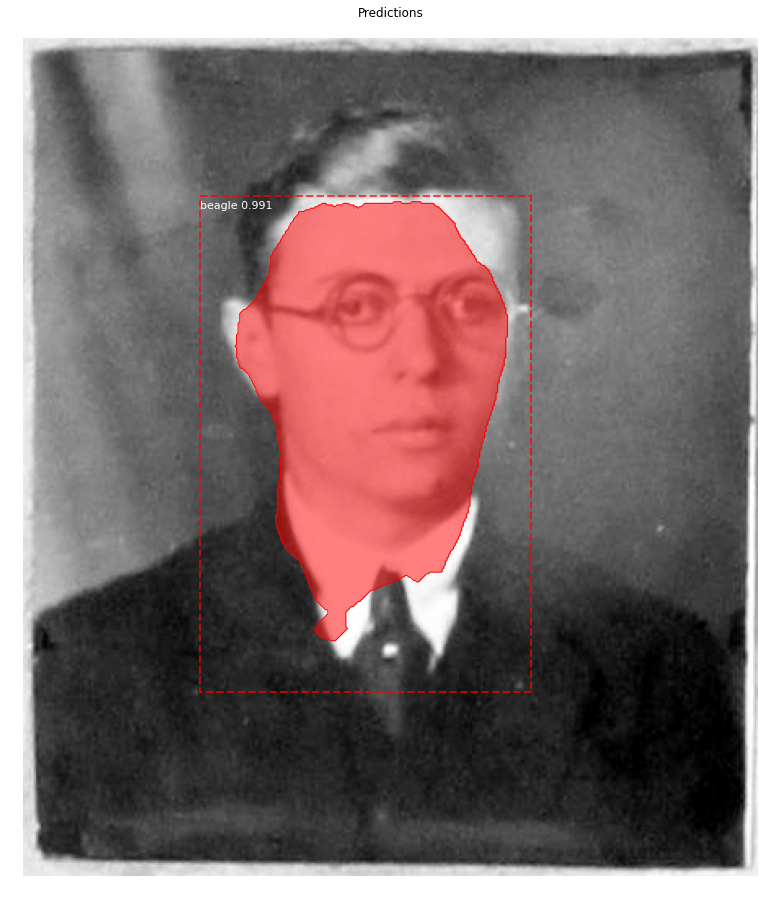

In [26]:
#run on arbitrary images
# Run object detection
name = "john paul sartre.jpg"
from google.colab import files
files.upload()
image = cv2.imread(name)
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)